# Estimation of tree height using GEDI dataset - Random Forest prediction


    pip install Pyspatialml

**Code**

In [1]:
import pandas as pd
import numpy as np
from rasterio import *
from rasterio.plot import show
from sklearn.ensemble import RandomForestRegressor as RFReg
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.pipeline import Pipeline
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,6.5)

read in data

In [2]:
predictors = pd.read_csv("tree_height/txt/eu_x_y_height_predictors_select.txt", sep=" ",  index_col=False)
pd.set_option('display.max_columns',None)
predictors.head(10)

,ID,X,Y,h,BLDFIE_WeigAver,CECSOL_WeigAver,CHELSA_bio18,CHELSA_bio4,convergence,cti,dev-magnitude,eastness,elev,forestheight,glad_ard_SVVI_max,glad_ard_SVVI_med,glad_ard_SVVI_min,northness,ORCDRC_WeigAver,outlet_dist_dw_basin,SBIO3_Isothermality_5_15cm,SBIO4_Temperature_Seasonality_5_15cm,treecover
0,1,6.050001,49.727499,3139.00,1540,13,2113,5893,-10.486560,-238043120,1.158417,0.069094,353.983124,23,276.871094,46.444092,347.665405,0.042500,9,780403,19.798992,440.672211,85
1,2,6.050002,49.922155,1454.75,1491,12,1993,5912,33.274361,-208915344,-1.755341,0.269112,267.511688,19,-49.526367,19.552734,-130.541748,0.182780,16,772777,20.889412,457.756195,85
2,3,6.050002,48.602377,853.50,1521,17,2124,5983,0.045293,-137479792,1.908780,-0.016055,389.751160,21,93.257324,50.743652,384.522461,0.036253,14,898820,20.695877,481.879700,62
3,4,6.050009,48.151979,3141.00,1526,16,2569,6130,-33.654274,-267223072,0.965787,0.067767,380.207703,27,542.401367,202.264160,386.156738,0.005139,15,831824,19.375000,479.410278,85
4,5,6.050010,49.588410,2065.25,1547,14,2108,5923,27.493824,-107809368,-0.162624,0.014065,308.042786,25,136.048340,146.835205,198.127441,0.028847,17,796962,18.777500,457.880066,85
5,6,6.050014,48.608456,1246.50,1515,19,2124,6010,-1.602039,17384282,1.447979,-0.018912,364.527100,18,221.339844,247.387207,480.387939,0.042747,14,897945,19.398880,474.331329,62
6,7,6.050016,48.571401,2938.75,1520,19,2169,6147,27.856503,-66516432,-1.073956,0.002280,254.679596,19,125.250488,87.865234,160.696777,0.037254,11,908426,20.170450,476.414520,96
7,8,6.050019,49.921613,3294.75,1490,12,1995,5912,22.102139,-297770784,-1.402633,0.309765,294.927765,26,-86.729492,-145.584229,-190.062988,0.222435,15,772784,20.855963,457.195404,86
8,9,6.050020,48.822645,1623.50,1554,18,1973,6138,18.496584,-25336536,-0.800016,0.010370,240.493759,22,-51.470703,-245.886719,172.074707,0.004428,8,839132,21.812290,496.231110,64
9,10,6.050024,49.847522,1400.00,1521,15,2187,5886,-5.660453,-278652608,1.477951,-0.068720,376.671143,12,277.297363,273.141846,-138.895996,0.098817,13,768873,21.137711,466.976685,70


In [3]:
len(predictors)

1267239

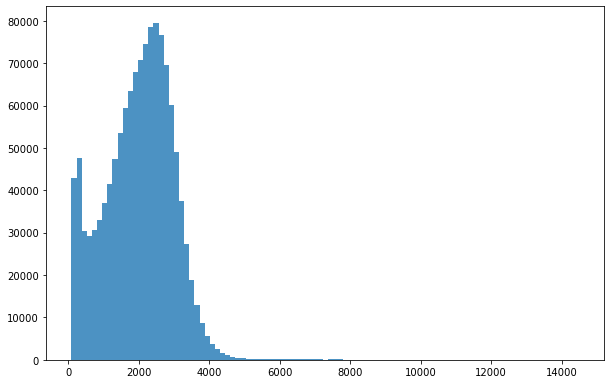

In [4]:
bins = np.linspace(min(predictors['h']),max(predictors['h']),100)
plt.hist((predictors['h']),bins,alpha=0.8);

In [5]:
predictors_sel = predictors.loc[(predictors['h'] < 8000)  & ( predictors['h'] > 300 )].sample(100000)
predictors_sel.insert ( 4, 'hm' ,  predictors_sel['h']/100 )
len(predictors_sel)
predictors_sel.head(10)

,ID,X,Y,h,hm,BLDFIE_WeigAver,CECSOL_WeigAver,CHELSA_bio18,CHELSA_bio4,convergence,cti,dev-magnitude,eastness,elev,forestheight,glad_ard_SVVI_max,glad_ard_SVVI_med,glad_ard_SVVI_min,northness,ORCDRC_WeigAver,outlet_dist_dw_basin,SBIO3_Isothermality_5_15cm,SBIO4_Temperature_Seasonality_5_15cm,treecover
1169231,1169232,9.531712,49.014526,2637.75,26.3775,1460,13,2825,6553,14.741976,65513460,-1.234663,-0.136787,359.731506,26,388.843872,180.184570,-282.092896,-0.032185,15,854664,19.974524,486.256927,87
1242642,1242643,9.829277,49.457428,1847.50,18.4750,1539,17,1880,6578,-10.230325,-190945552,0.450617,-0.028938,331.827881,26,184.586914,-44.678223,41.607666,0.076611,4,802882,17.801113,487.997589,74
616944,616945,7.794376,49.936491,2366.00,23.6600,1510,15,1784,6281,-0.818384,-246739456,0.441385,-0.151280,283.319794,25,-75.419434,-94.947998,157.605469,0.065698,17,564287,18.662825,480.487823,100
767204,767205,8.481658,49.032304,2899.25,28.9925,1531,15,2194,6621,14.723026,-102499456,-1.473219,-0.014258,113.876358,7,429.215332,342.055420,190.835205,0.008521,9,720756,20.647640,526.152283,58
468691,468692,7.376594,48.612262,2218.50,22.1850,1452,14,2458,6243,-30.829910,-301616576,0.758155,0.190411,416.462891,18,-273.131836,-69.275391,302.972412,-0.009835,12,843576,18.453840,454.174988,100
462738,462739,7.363206,48.893333,1299.00,12.9900,1530,12,2215,6279,27.085413,-146318224,-0.848093,0.000530,263.739227,21,110.141113,30.604004,17.626221,0.086956,12,827881,19.378300,450.723511,81
978862,978863,9.042125,49.550580,2780.25,27.8025,1419,14,2590,6336,15.300125,-240752992,1.505054,-0.177774,424.673187,12,206.607666,194.658447,192.613281,-0.167651,14,725453,20.389563,456.661469,97
155636,155637,6.614136,49.562878,1665.25,16.6525,1470,14,2157,6094,4.690185,-326497536,-0.901392,-0.403319,280.093964,26,53.966064,-198.623779,-30.289062,0.367745,9,711778,22.860306,476.047302,95
264836,264837,6.899491,49.920169,1742.50,17.4250,1521,12,2077,6144,-1.932333,-280227296,1.694332,-0.145662,328.881500,25,-7.561035,-90.229980,37.742676,0.115312,16,638509,18.627163,446.605194,86
569329,569330,7.661671,49.713490,1236.50,12.3650,1482,15,1690,6535,9.911312,91682800,-2.013998,0.045590,154.322189,6,604.629395,510.784668,573.699707,0.007721,15,589327,22.766729,536.697205,39


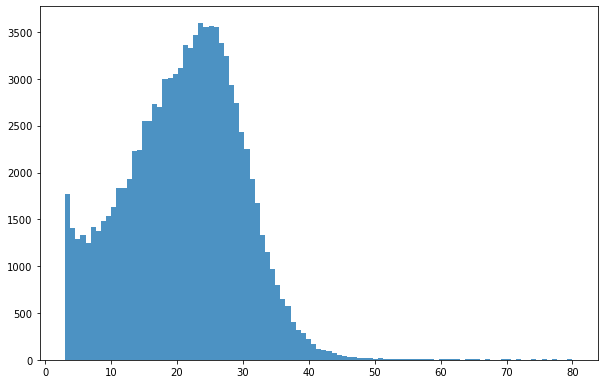

In [6]:
bins = np.linspace(min(predictors_sel['hm']),max(predictors_sel['hm']),100)
plt.hist((predictors_sel['hm']),bins,alpha=0.8);

0.4527925129990053

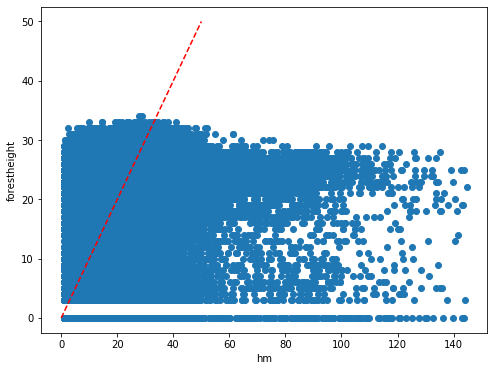

In [7]:
plt.rcParams["figure.figsize"] = (8,6)
plt.scatter(predictors['h']/100,predictors['forestheight'])
plt.xlabel('hm')
plt.ylabel('forestheight')
ident = [0, 50]
plt.plot(ident,ident,'r--')
pearsonr(predictors['h'],predictors['forestheight'])[0]

In [8]:
X = predictors_sel.iloc[:,[5,6,7,8,9,10,11,12,13,15,16,17,18,19,20,21,22,23]].values
Y = predictors_sel.iloc[:,4:5].values
feat = predictors_sel.iloc[:,[5,6,7,8,9,10,11,12,13,15,16,17,18,19,20,21,22,23]].columns.values

In [9]:
Y

array([[26.3775],
       [18.475 ],
       [23.66  ],
       ...,
       [13.8125],
       [14.5225],
       [30.6525]])

In [10]:
X

array([[1460.        ,   13.        , 2825.        , ...,   19.97452354,
         486.25692749,   87.        ],
       [1539.        ,   17.        , 1880.        , ...,   17.80111313,
         487.99758911,   74.        ],
       [1510.        ,   15.        , 1784.        , ...,   18.66282463,
         480.48782349,  100.        ],
       ...,
       [1535.        ,   16.        , 2140.        , ...,   20.49588776,
         525.11340332,   18.        ],
       [1532.        ,   14.        , 1777.        , ...,   21.25732994,
         495.80603027,   27.        ],
       [1549.        ,   14.        , 2139.        , ...,   18.1689415 ,
         471.93032837,   89.        ]])

In [11]:
Y.shape

(100000, 1)

In [12]:
X.shape

(100000, 18)

**Model building**

In [13]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.5, random_state=24)
y_train = np.ravel(Y_train)
y_test = np.ravel(Y_test)

### Random Forest default parameters

In [14]:
rf = RFReg(random_state = 42)
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [ ]:
rfReg = RFReg()
rfReg.fit(X_train, y_train);
dic_pred = {}
dic_pred['train'] = rfReg.predict(X_train)
dic_pred['test'] = rfReg.predict(X_test)
pearsonr_all = [pearsonr(dic_pred['train'],y_train)[0],pearsonr(dic_pred['test'],y_test)[0]]
pearsonr_all

### Random Forest tuning


* "max_features": number of features to consider when looking for the best split. 
* "max_samples": number of samples to draw from X to train each base estimator.
* "n_estimators": identify the number of trees that must grow. It must be large enough so that the error is stabilized. Defoult 100.
* "max_depth": max number of levels in each decision tree.

In [ ]:
pipeline = Pipeline([('rf',RFReg())])

parameters = {
        'rf__max_features':(3,4,5),
        'rf__max_samples':(0.5,0.6,0.7),
        'rf__n_estimators':(500,1000),
        'rf__max_depth':(50,100,200,300)}

grid_search = GridSearchCV(pipeline,parameters,n_jobs=6,cv=5,scoring='r2',verbose=1)
grid_search.fit(X_train,y_train)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


In [ ]:
rfReg = RFReg(n_estimators=5000,max_features=0.33,max_depth=500,max_samples=0.7,n_jobs=-1,random_state=24 , oob_score =  True)
rfReg.fit(X_train, y_train);
dic_pred = {}
dic_pred['train'] = rfReg.predict(X_train)
dic_pred['test'] = rfReg.predict(X_test)
pearsonr_all_toone = [pearsonr(dic_pred['train'],y_train)[0],pearsonr(dic_pred['test'],y_test)[0]]
pearsonr_all_toone

In [15]:
grid_search.best_score_

0.20414830330946446

In [16]:
print ('Best Training score: %0.3f' % grid_search.best_score_)
print ('Optimal parameters:')
best_par = grid_search.best_estimator_.get_params()
for par_name in sorted(parameters.keys()):
    print ('\t%s: %r' % (par_name, best_par[par_name]))


Best Training score: 0.204
Optimal parameters:
	rf__max_depth: 500
	rf__max_features: 0.33
	rf__max_samples: 0.6
	rf__n_estimators: 2000


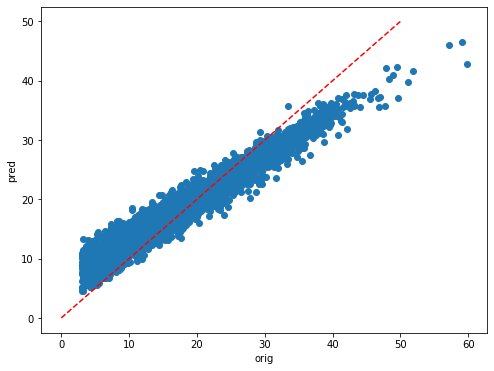

In [50]:
plt.rcParams["figure.figsize"] = (8,6)
plt.scatter(y_train,dic_pred['train'])
plt.xlabel('orig')
plt.ylabel('pred')
ident = [0, 50]
plt.plot(ident,ident,'r--')

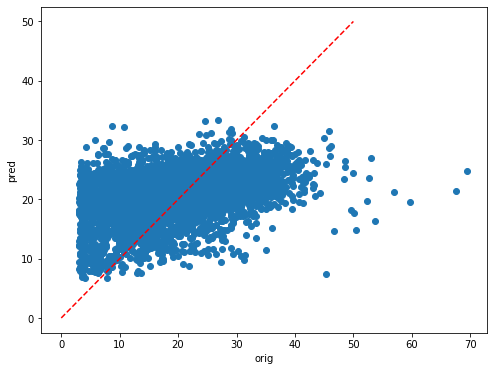

In [51]:
plt.rcParams["figure.figsize"] = (8,6)
plt.scatter(y_test,dic_pred['test'])
plt.xlabel('orig')
plt.ylabel('pred')
ident = [0, 50]
plt.plot(ident,ident,'r--')

In [20]:
impt = [rfReg.feature_importances_, np.std([tree.feature_importances_ for tree in rfReg.estimators_],axis=1)] 
ind = np.argsort(impt[0])

In [21]:
ind

array([ 1, 13,  0,  6,  8,  5,  4, 16,  3, 12, 15,  2, 14,  9,  7, 11, 10,
       17])

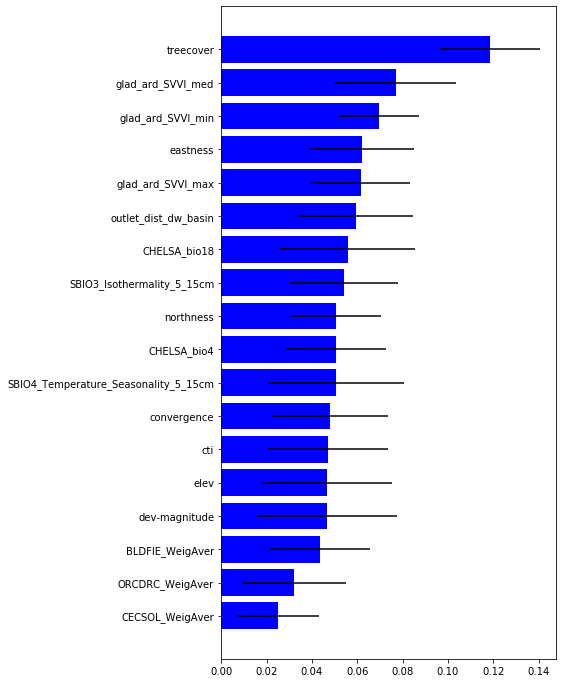

In [22]:
plt.rcParams["figure.figsize"] = (6,12)
plt.barh(range(len(feat)),impt[0][ind],color="b", xerr=impt[1][ind], align="center")
plt.yticks(range(len(feat)),feat[ind]);

**File storing tree hight (cm) obtained by 6 algorithms, with their associate quality flags.**
The quality flags can be used to refine and select the best tree height estimation and use it as tree height observation.

* a?_95: tree hight (cm) at 95 quintile, for each algorithm  
* min_rh_95: minimum value of tree hight (cm) ammong the 6 algorithms  
* max_rh_95: maximum value of tree hight (cm) ammong the 6 algorithms  
* BEAM: 1-4 coverage beam = lower power (worse) ; 5-8 power beam = higher power (better)  
* digital_elev: digital mdoel elevation  
* elev_low: elevation of center of lowest mode  
* qc_a?: quality_flag for six algorithms quality_flag = 1 (better); = 0 (worse)  
* se_a?: sensitivity for six algorithms sensitivity < 0.95 (worse);  sensitivity > 0.95  (beter )  
* deg_fg: (degrade_flag) not-degraded 0 (better) ;  degraded > 0 (worse)  
* solar_ele: solar elevation. > 0 day (worse); < 0 night (better)  

In [55]:
height_6algorithms = pd.read_csv("tree_height/txt/eu_y_x_select_6algorithms_fullTable.txt", sep=" ",  index_col=False)
pd.set_option('display.max_columns',None)
height_6algorithms.head(6)

,ID,X,Y,a1_95,a2_95,a3_95,a4_95,a5_95,a6_95,min_rh_95,max_rh_95,BEAM,digital_elev,elev_low,qc_a1,qc_a2,qc_a3,qc_a4,qc_a5,qc_a6,se_a1,se_a2,se_a3,se_a4,se_a5,se_a6,deg_fg,solar_ele
0,1,6.050001,49.727499,3139,3139,3139,3120,3139,3139,3120,3139,5,410.0,383.72153,1,1,1,1,1,1,0.962,0.984,0.968,0.962,0.989,0.979,0,17.7
1,2,6.050002,49.922155,1022,2303,970,872,5596,1524,872,5596,5,290.0,2374.14110,0,0,0,0,0,0,0.948,0.990,0.960,0.948,0.994,0.980,0,43.7
2,3,6.050002,48.602377,380,1336,332,362,1336,1340,332,1340,4,440.0,435.97781,1,1,1,1,1,1,0.947,0.975,0.956,0.947,0.981,0.968,0,0.2
3,4,6.050009,48.151979,3153,3142,3142,3127,3138,3142,3127,3153,2,450.0,422.00537,1,1,1,1,1,1,0.930,0.970,0.943,0.930,0.978,0.962,0,-14.2
4,5,6.050010,49.588410,666,4221,651,33,5611,2723,33,5611,8,370.0,2413.74830,0,0,0,0,0,0,0.941,0.983,0.946,0.941,0.992,0.969,0,22.1
5,6,6.050014,48.608456,787,1179,1187,761,1833,1833,761,1833,3,420.0,415.51581,1,1,1,1,1,1,0.952,0.979,0.961,0.952,0.986,0.975,0,0.2


In [56]:
height_6algorithms_sel = height_6algorithms.loc[(height_6algorithms['BEAM'] > 4) 
                                            &   (height_6algorithms['qc_a1'] == 1)
                                            &   (height_6algorithms['qc_a2'] == 1)
                                            &   (height_6algorithms['qc_a3'] == 1)    
                                            &   (height_6algorithms['qc_a4'] == 1)    
                                            &   (height_6algorithms['qc_a5'] == 1)    
                                            &   (height_6algorithms['qc_a6'] == 1)
                                            &   (height_6algorithms['se_a1'] > 0.95)    
                                            &   (height_6algorithms['se_a2'] > 0.95)
                                            &   (height_6algorithms['se_a3'] > 0.95)
                                            &   (height_6algorithms['se_a4'] > 0.95)
                                            &   (height_6algorithms['se_a5'] > 0.95)   
                                            &   (height_6algorithms['se_a6'] > 0.95)
                                            &   (height_6algorithms['deg_fg'] == 0)  
                                            &   (height_6algorithms['solar_ele'] < 0)]

In [57]:
height_6algorithms_sel

,ID,X,Y,a1_95,a2_95,a3_95,a4_95,a5_95,a6_95,min_rh_95,max_rh_95,BEAM,digital_elev,elev_low,qc_a1,qc_a2,qc_a3,qc_a4,qc_a5,qc_a6,se_a1,se_a2,se_a3,se_a4,se_a5,se_a6,deg_fg,solar_ele
7,8,6.050019,49.921613,3303,3288,3296,3236,3857,3292,3236,3857,7,320.0,297.68533,1,1,1,1,1,1,0.971,0.988,0.976,0.971,0.992,0.984,0,-33.9
11,12,6.050039,47.995344,2762,2736,2740,2747,3893,2736,2736,3893,5,390.0,368.55121,1,1,1,1,1,1,0.975,0.990,0.979,0.975,0.994,0.987,0,-37.3
14,15,6.050046,49.865317,1398,2505,2509,1316,2848,2505,1316,2848,6,340.0,330.40564,1,1,1,1,1,1,0.973,0.990,0.979,0.973,0.994,0.986,0,-18.2
15,16,6.050048,49.050020,984,943,947,958,2617,947,943,2617,6,300.0,291.22598,1,1,1,1,1,1,0.978,0.991,0.982,0.978,0.995,0.988,0,-35.4
16,17,6.050049,48.391359,3362,3332,3336,3351,4467,3336,3332,4467,5,530.0,504.78122,1,1,1,1,1,1,0.973,0.988,0.977,0.973,0.992,0.984,0,-5.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1267207,1267208,9.949829,49.216272,2160,2816,2816,2104,3299,2816,2104,3299,8,420.0,386.44556,1,1,1,1,1,1,0.980,0.993,0.984,0.980,0.995,0.989,0,-16.9
1267211,1267212,9.949856,49.881190,3190,3179,3179,3171,3822,3179,3171,3822,6,380.0,363.69348,1,1,1,1,1,1,0.968,0.986,0.974,0.968,0.990,0.982,0,-35.1
1267216,1267217,9.949880,49.873435,2061,2828,2046,2024,2828,2828,2024,2828,7,380.0,361.06812,1,1,1,1,1,1,0.967,0.988,0.974,0.967,0.993,0.983,0,-35.1
1267227,1267228,9.949958,49.127182,366,2307,1260,355,3531,2719,355,3531,6,500.0,493.52792,1,1,1,1,1,1,0.973,0.989,0.978,0.973,0.993,0.985,0,-36.0


In [58]:
height_sel =  pd.DataFrame({'ID' : height_6algorithms_sel['ID'] , 
                            'hm_sel': (height_6algorithms_sel['a1_95'] + height_6algorithms_sel['a2_95'] + height_6algorithms_sel['a3_95'] + height_6algorithms_sel['a4_95'] 
                             + height_6algorithms_sel['a5_95'] + height_6algorithms_sel['a6_95'] - height_6algorithms_sel['min_rh_95'] - height_6algorithms_sel['max_rh_95']) / 400 } )

In [59]:
height_sel

,ID,hm_sel
7,8,32.9475
11,12,27.4625
14,15,22.2925
15,16,9.5900
16,17,33.4625
...,...,...
1267207,1267208,26.5200
1267211,1267212,31.8175
1267216,1267217,24.4075
1267227,1267228,16.6300


In [60]:
predictors_hm_sel = pd.merge( predictors ,  height_sel , left_on='ID' ,  right_on='ID' ,  how='right')

In [61]:
predictors.head(15)

,ID,X,Y,h,BLDFIE_WeigAver,CECSOL_WeigAver,CHELSA_bio18,CHELSA_bio4,convergence,cti,dev-magnitude,eastness,elev,forestheight,glad_ard_SVVI_max,glad_ard_SVVI_med,glad_ard_SVVI_min,northness,ORCDRC_WeigAver,outlet_dist_dw_basin,SBIO3_Isothermality_5_15cm,SBIO4_Temperature_Seasonality_5_15cm,treecover
0,1,6.050001,49.727499,3139.00,1540,13,2113,5893,-10.486560,-238043120,1.158417,0.069094,353.983124,23,276.871094,46.444092,347.665405,0.042500,9,780403,19.798992,440.672211,85
1,2,6.050002,49.922155,1454.75,1491,12,1993,5912,33.274361,-208915344,-1.755341,0.269112,267.511688,19,-49.526367,19.552734,-130.541748,0.182780,16,772777,20.889412,457.756195,85
2,3,6.050002,48.602377,853.50,1521,17,2124,5983,0.045293,-137479792,1.908780,-0.016055,389.751160,21,93.257324,50.743652,384.522461,0.036253,14,898820,20.695877,481.879700,62
3,4,6.050009,48.151979,3141.00,1526,16,2569,6130,-33.654274,-267223072,0.965787,0.067767,380.207703,27,542.401367,202.264160,386.156738,0.005139,15,831824,19.375000,479.410278,85
4,5,6.050010,49.588410,2065.25,1547,14,2108,5923,27.493824,-107809368,-0.162624,0.014065,308.042786,25,136.048340,146.835205,198.127441,0.028847,17,796962,18.777500,457.880066,85
5,6,6.050014,48.608456,1246.50,1515,19,2124,6010,-1.602039,17384282,1.447979,-0.018912,364.527100,18,221.339844,247.387207,480.387939,0.042747,14,897945,19.398880,474.331329,62
6,7,6.050016,48.571401,2938.75,1520,19,2169,6147,27.856503,-66516432,-1.073956,0.002280,254.679596,19,125.250488,87.865234,160.696777,0.037254,11,908426,20.170450,476.414520,96
7,8,6.050019,49.921613,3294.75,1490,12,1995,5912,22.102139,-297770784,-1.402633,0.309765,294.927765,26,-86.729492,-145.584229,-190.062988,0.222435,15,772784,20.855963,457.195404,86
8,9,6.050020,48.822645,1623.50,1554,18,1973,6138,18.496584,-25336536,-0.800016,0.010370,240.493759,22,-51.470703,-245.886719,172.074707,0.004428,8,839132,21.812290,496.231110,64
9,10,6.050024,49.847522,1400.00,1521,15,2187,5886,-5.660453,-278652608,1.477951,-0.068720,376.671143,12,277.297363,273.141846,-138.895996,0.098817,13,768873,21.137711,466.976685,70


In [62]:
height_sel

,ID,hm_sel
7,8,32.9475
11,12,27.4625
14,15,22.2925
15,16,9.5900
16,17,33.4625
...,...,...
1267207,1267208,26.5200
1267211,1267212,31.8175
1267216,1267217,24.4075
1267227,1267228,16.6300


In [63]:
predictors_hm_sel

,ID,X,Y,h,BLDFIE_WeigAver,CECSOL_WeigAver,CHELSA_bio18,CHELSA_bio4,convergence,cti,dev-magnitude,eastness,elev,forestheight,glad_ard_SVVI_max,glad_ard_SVVI_med,glad_ard_SVVI_min,northness,ORCDRC_WeigAver,outlet_dist_dw_basin,SBIO3_Isothermality_5_15cm,SBIO4_Temperature_Seasonality_5_15cm,treecover,hm_sel
0,8,6.050019,49.921613,3294.75,1490,12,1995,5912,22.102139,-297770784,-1.402633,0.309765,294.927765,26,-86.729492,-145.584229,-190.062988,0.222435,15,772784,20.855963,457.195404,86,32.9475
1,12,6.050039,47.995344,2746.25,1523,12,2612,6181,3.549103,-71279992,0.507727,-0.021408,322.920227,26,660.006104,92.722168,190.979736,-0.034787,16,784807,20.798000,460.501221,97,27.4625
2,15,6.050046,49.865317,2229.25,1517,13,2191,5901,31.054762,-186807440,-1.375050,-0.126880,291.412537,7,1028.385498,915.806396,841.586182,0.024677,16,766444,19.941267,454.185089,54,22.2925
3,16,6.050048,49.050020,959.00,1526,14,2081,6100,9.933455,-183562672,-0.382834,0.086874,246.288010,24,-12.283691,-58.179199,174.205566,0.094175,10,805730,19.849365,470.946533,78,9.5900
4,17,6.050049,48.391359,3346.25,1489,19,2486,5966,-6.957157,-273522688,2.989759,0.214769,474.409088,24,125.583008,6.154297,128.129150,0.017164,15,950190,21.179420,491.398376,85,33.4625
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
226887,1267208,9.949829,49.216272,2652.00,1510,21,2239,6711,-1.048068,-231616096,-2.679006,-0.096388,335.430817,5,1117.387451,91.064941,324.314453,-0.134163,10,865865,20.274633,518.567444,72,26.5200
226888,1267212,9.949856,49.881190,3181.75,1534,13,2056,6503,-34.868324,-279072288,1.083573,0.055990,320.695648,24,82.510742,81.327637,274.534668,-0.070041,10,855471,17.125103,473.745728,78,31.8175
226889,1267217,9.949880,49.873435,2440.75,1513,14,2031,6486,5.590047,-238339568,0.961292,-0.098397,319.854309,24,133.571045,120.405518,319.006470,0.135788,8,854918,18.293501,494.363525,85,24.4075
226890,1267228,9.949958,49.127182,1663.00,1541,16,2591,6632,32.355999,102099440,-1.016537,-0.002035,437.341034,25,-16.909180,53.518555,303.941162,0.020682,10,860474,18.277027,487.254395,97,16.6300


In [64]:
predictors_hm_sel.loc[(predictors['h'] < 8000)  & ( predictors['h'] > 300 )].sample(10000)

,ID,X,Y,h,BLDFIE_WeigAver,CECSOL_WeigAver,CHELSA_bio18,CHELSA_bio4,convergence,cti,dev-magnitude,eastness,elev,forestheight,glad_ard_SVVI_max,glad_ard_SVVI_med,glad_ard_SVVI_min,northness,ORCDRC_WeigAver,outlet_dist_dw_basin,SBIO3_Isothermality_5_15cm,SBIO4_Temperature_Seasonality_5_15cm,treecover,hm_sel
195678,1097258,9.334078,49.619868,2794.00,1546,12,2124,6409,-11.649844,-229633024,1.316271,-0.013485,429.172455,22,-10.994385,-144.848633,-414.120850,0.086094,12,727521,19.890150,485.002502,58,27.9400
31711,174064,6.664047,49.425667,460.00,1503,18,2137,6066,25.703257,-101682208,1.240938,-0.103657,337.064728,8,171.120850,256.611328,554.586670,0.008597,12,743280,22.750713,485.201324,43,4.6000
3073,15673,6.090988,48.070861,1516.00,1525,14,2591,6158,59.335327,183848624,-1.517122,0.000638,338.694031,21,254.364990,275.723389,318.574219,0.009850,22,823079,20.399702,474.051086,85,15.1600
208592,1174938,9.551139,49.770397,2114.50,1523,15,1813,6698,-1.434988,-171646688,1.655684,0.009652,222.426636,24,48.300537,-122.063477,-256.039795,0.024145,23,746881,19.330082,491.192932,85,21.1450
34988,193179,6.717209,49.451559,2867.75,1536,16,2389,6013,-13.811592,-196965920,2.292098,0.094432,408.874817,24,213.646484,-10.833008,167.374756,0.017682,10,759015,21.862015,474.616150,85,28.6775
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222158,1240666,9.821090,49.862307,1699.75,1514,16,1911,6502,-41.271114,-281414208,1.708344,-0.133984,337.290802,17,327.427002,180.356445,55.604492,-0.082052,10,833680,18.511948,484.010834,72,16.9975
44360,243097,6.842313,49.178386,2331.50,1527,12,2023,6268,43.187695,-64854832,-1.407103,-0.079063,215.257263,25,295.679688,-3.004883,31.070679,0.077709,9,782261,18.606712,459.909241,89,23.3150
53204,289337,6.961452,48.893853,3035.75,1534,12,2151,6302,-7.667385,-77615832,1.325887,0.034342,254.128601,29,876.000488,320.792236,415.007812,-0.007584,7,849604,18.075121,457.555237,97,30.3575
153080,871478,8.770948,49.718612,2819.50,1502,14,2861,5977,-70.388268,-292548320,3.220833,0.026796,594.417114,26,840.798584,389.013916,457.876953,-0.086764,15,700720,22.353367,454.097687,100,28.1950


In [65]:
X = predictors_hm_sel.iloc[:,[5,6,7,8,9,10,11,12,13,15,16,17,18,19,20,21,22,23]].values
Y = predictors_hm_sel.iloc[:,23:24].values
feat = predictors_sel.iloc[:,[5,6,7,8,9,10,11,12,13,15,16,17,18,19,20,21,22,23]].columns.values

In [66]:
Y.shape

(226892, 1)

In [67]:
X.shape

(226892, 18)

In [36]:
pipeline = Pipeline([('rf',RFReg())])

parameters = {
        'rf__max_features':("log2","sqrt",0.33),
        'rf__max_samples':(0.5,0.6,0.7),
        'rf__n_estimators':(500,1000),
        'rf__max_depth':(50,100,200)}

grid_search = GridSearchCV(pipeline,parameters,n_jobs=-1,cv=3,scoring='r2',verbose=1)
grid_search.fit(X_train,y_train)

Fitting 3 folds for each of 144 candidates, totalling 432 fits


GridSearchCV(cv=3, estimator=Pipeline(steps=[('rf', RandomForestRegressor())]),
             n_jobs=-1,
             param_grid={'rf__max_depth': (50, 100, 200, 500),
                         'rf__max_features': ('log2', 'sqrt', 0.33),
                         'rf__max_samples': (0.5, 0.6, 0.7, 0.8),
                         'rf__n_estimators': (500, 1000, 2000)},
             scoring='r2', verbose=1)

In [37]:
grid_search.best_score_

0.2046063266475514

In [38]:
print ('Best Training score: %0.3f' % grid_search.best_score_)
print ('Optimal parameters:')
best_par = grid_search.best_estimator_.get_params()
for par_name in sorted(parameters.keys()):
    print ('\t%s: %r' % (par_name, best_par[par_name]))


Best Training score: 0.205
Optimal parameters:
	rf__max_depth: 200
	rf__max_features: 0.33
	rf__max_samples: 0.7
	rf__n_estimators: 1000


In [39]:
rfReg = RFReg(n_estimators=500,max_features='sqrt',max_depth=50,max_samples=0.6,n_jobs=-1,random_state=24)
rfReg.fit(X_train, y_train);
dic_pred = {}
dic_pred['train'] = rfReg.predict(X_train)
dic_pred['test'] = rfReg.predict(X_test)
[pearsonr(dic_pred['train'],y_train)[0],pearsonr(dic_pred['test'],y_test)[0]]

[0.9398826518204161, 0.4472629935798444]

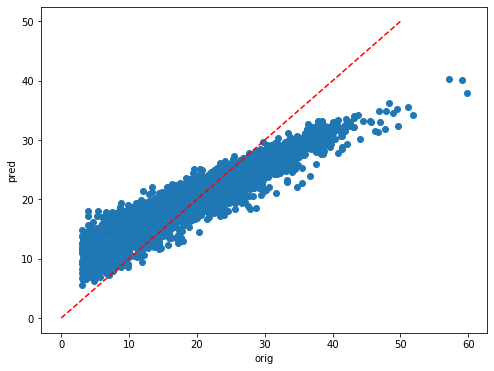

In [40]:
plt.rcParams["figure.figsize"] = (8,6)
plt.scatter(y_train,dic_pred['train'])
plt.xlabel('orig')
plt.ylabel('pred')
ident = [0, 50]
plt.plot(ident,ident,'r--')

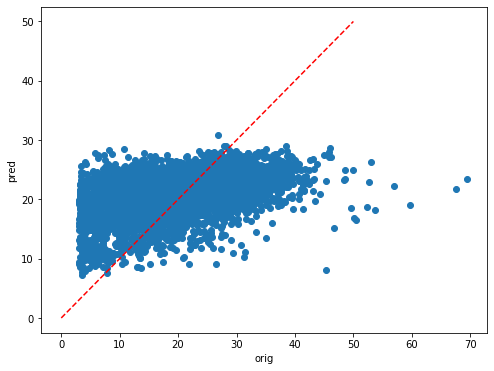

In [41]:
plt.rcParams["figure.figsize"] = (8,6)
plt.scatter(y_test,dic_pred['test'])
plt.xlabel('orig')
plt.ylabel('pred')
ident = [0, 50]
plt.plot(ident,ident,'r--')

In [42]:
impt = [rfReg.feature_importances_, np.std([tree.feature_importances_ for tree in rfReg.estimators_],axis=1)] 
ind = np.argsort(impt[0])

In [43]:
ind

array([ 1, 13,  0,  5,  6,  8,  4, 12,  3, 16, 15,  2, 14,  7,  9, 11, 10,
       17])

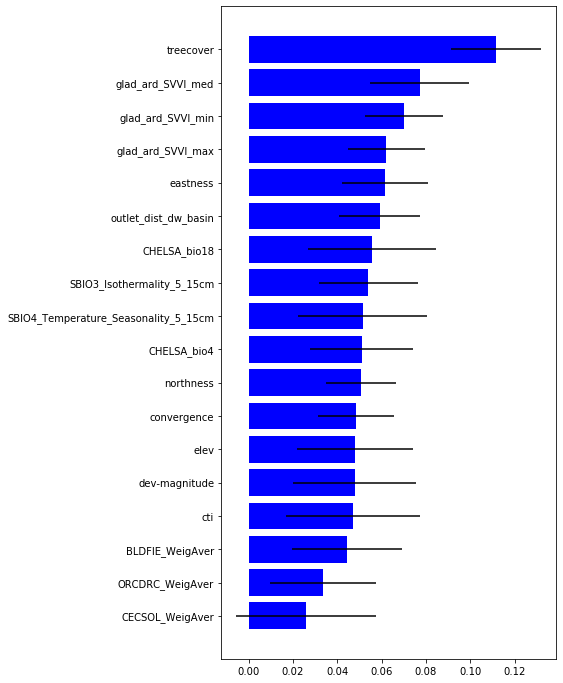

In [44]:
plt.rcParams["figure.figsize"] = (6,12)
plt.barh(range(len(feat)),impt[0][ind],color="b", xerr=impt[1][ind], align="center")
plt.yticks(range(len(feat)),feat[ind]);

In [ ]:
# import satalite indeces
glad_ard_SVVI_min = rasterio.open("tree_height/geodata_raster/glad_ard_SVVI_min.tif")
glad_ard_SVVI_med = rasterio.open("tree_height/geodata_raster/glad_ard_SVVI_med.tif")
glad_ard_SVVI_max = rasterio.open("tree_height/geodata_raster/glad_ard_SVVI_max.tif")

# import climate
CHELSA_bio4 = rasterio.open("tree_height/geodata_raster/CHELSA_bio4.tif")
CHELSA_bio18 = rasterio.open("tree_height/geodata_raster/CHELSA_bio18.tif")


BLDFIE_WeigAver = rasterio.open("tree_height/geodata_raster/BLDFIE_WeigAver.tif")
CECSOL_WeigAver = rasterio.open("tree_height/geodata_raster/CECSOL_WeigAver.tif")
ORCDRC_WeigAver = rasterio.open("tree_height/geodata_raster/ORCDRC_WeigAver.tif")






In [ ]:
predictors_rasters = [glad_ard_SVVI_min, glad_ard_SVVI_min, glad_ard_SVVI_med, glad_ard_SVVI_max]
stack = Raster(redictors_rasters)